In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA

In [2]:
data = pd.read_csv("msft.us.txt")

# Data set
For the data I used the price of Microsoft stock from 1983-2017 and only the "Open" collum price is used.  
The open column corresponds to the opening price of the stock on a given day.  
The Dataset can be found [here](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)

## Preprocessing
---

In [3]:
data.isna().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [4]:
data = data['Open']
data.describe()

count    7983.000000
mean       18.977859
std        16.416068
min         0.067200
25%         2.113300
50%        20.462000
75%        25.475000
max        84.770000
Name: Open, dtype: float64

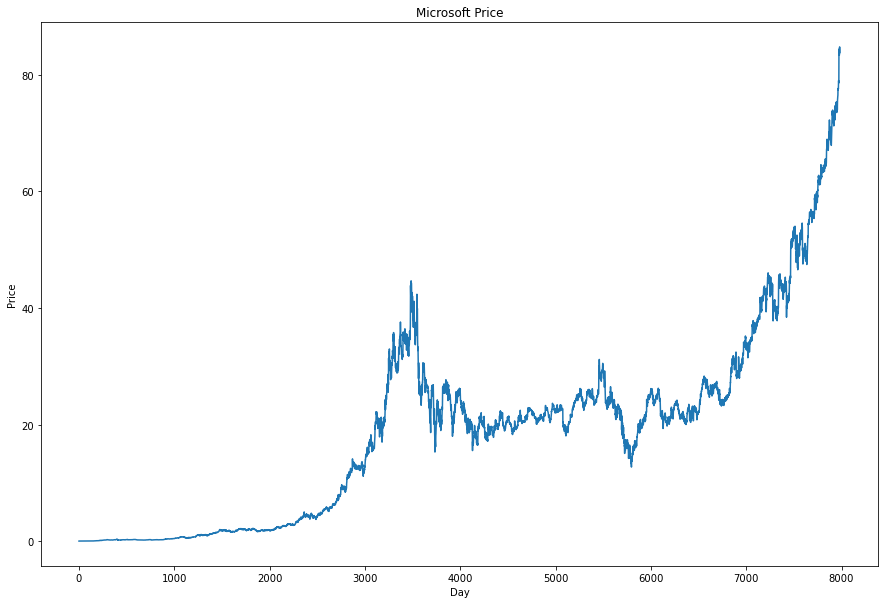

In [5]:
plt.figure(figsize=(15,10))
plt.plot(data)
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Microsoft Price')
plt.show()

# Autocorrelation
Autocorrelation is defined as:
![Autocorrelation](https://wikimedia.org/api/rest_v1/media/math/render/svg/e84a9862bb3aaaa68d29f45a6cc77b4b0d0e3460)

We can check the autocorrelation using a lag plot.
If our data shows a linear pattern, it suggests autocorrelation is present. A positive linear trend (i.e. going upwards from left to right) is suggestive of positive autocorrelation; a negative linear trend (going downwards from left to right) is suggestive of negative autocorrelation. The tighter the data is clustered around the diagonal, the more autocorrelation is present; perfectly autocorrelated data will cluster in a single diagonal line.

Text(0.5, 1.0, 'Autocorrelation lag 1')

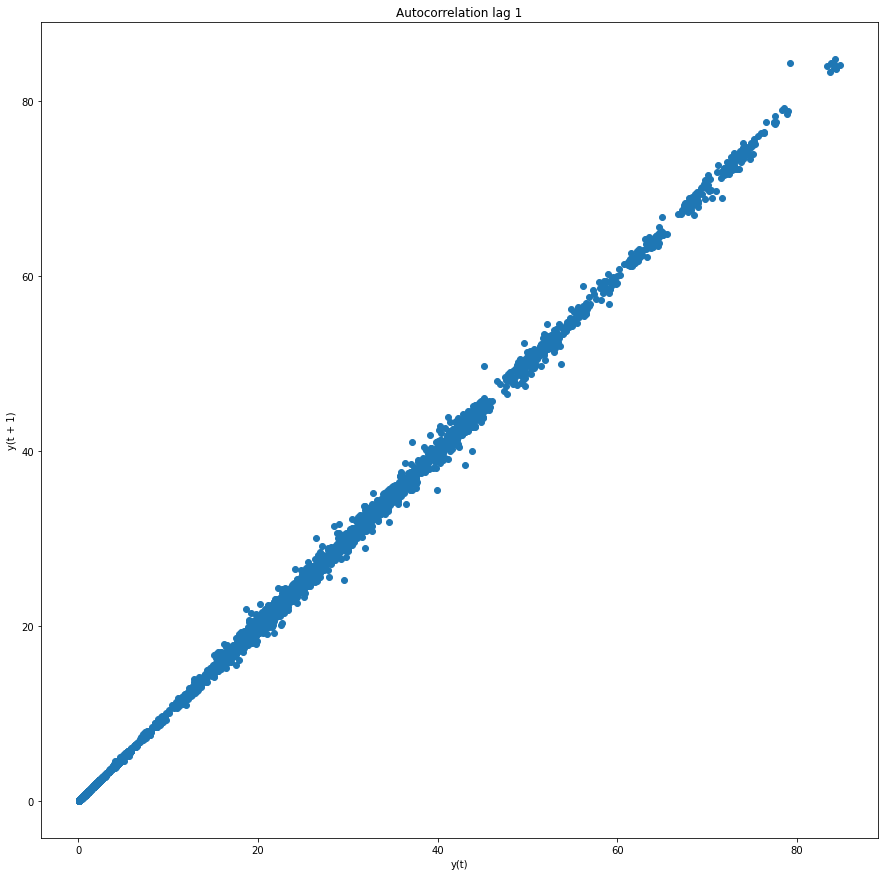

In [6]:
plt.figure(figsize=(15,15))
lag_plot(data, lag=1)
plt.title('Autocorrelation lag 1')

Text(0.5, 1.0, 'Autocorrelation lag 4')

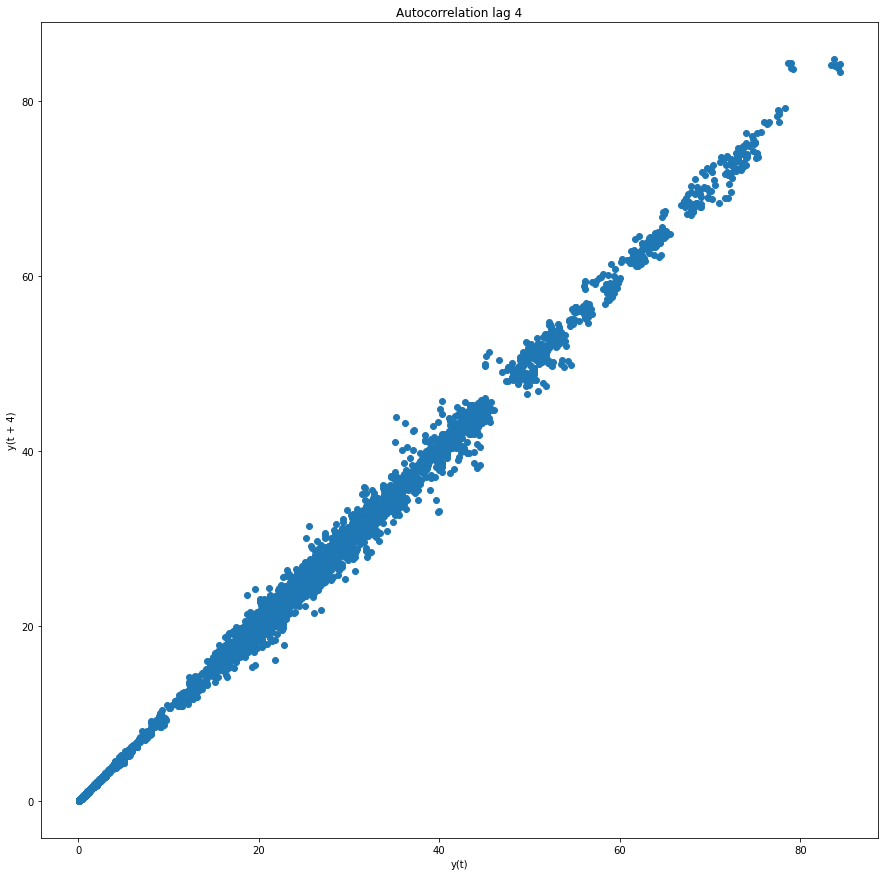

In [7]:
plt.figure(figsize=(15,15))
lag_plot(data, lag=4)
plt.title('Autocorrelation lag 4')

### As we can see the data gets more spread out from the diagonal as we increase the lag

Text(0.5, 1.0, 'Autocorrelation lag 5')

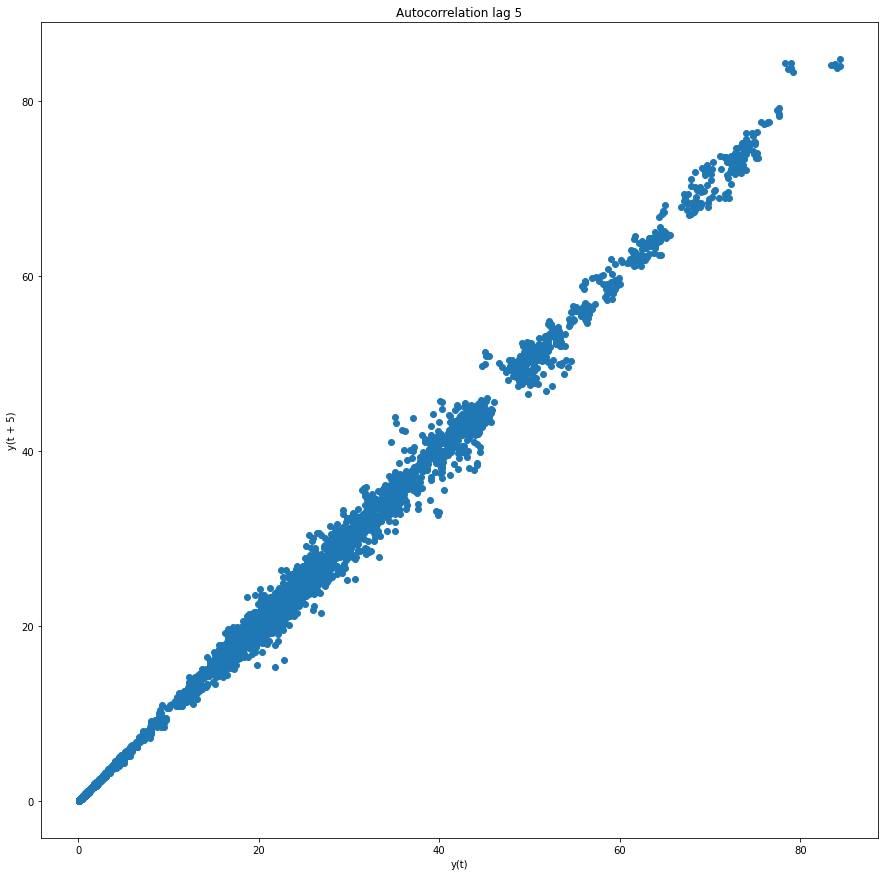

In [8]:
plt.figure(figsize=(15,15))
lag_plot(data, lag=5)
plt.title('Autocorrelation lag 5')

## Train test split

For the test data I chose 100 successive days to see how well it will preform given a long time frame. 
The training data consists of 2000 days (after testing more data does not improve results)

In [9]:
time_period = int(len(data)) - 2100
forcasting_days = int(len(data)) - 100

train_data = data[time_period : forcasting_days]
test_data = data[forcasting_days:]

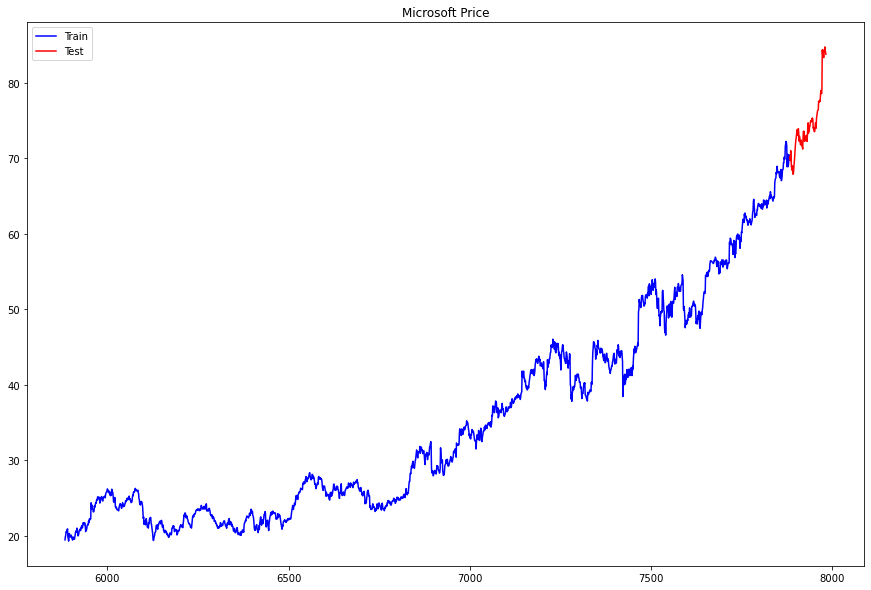

In [10]:
plt.figure(figsize=(15,10))
plt.plot(train_data, 'blue', label='Train')
plt.plot(test_data, 'red', label='Test')
plt.title('Microsoft Price')
plt.legend()
plt.show()

# Loss functions
To see how the model is performing I choose [SMPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) which is regularly used for measuring how  time series models are preforming. ![SMPE](https://wikimedia.org/api/rest_v1/media/math/render/svg/9d7003eba8a7ffe2379cd5c232adf78daa3d1edf) and I used [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) to see the difference between the two loss functions.
![MSE](https://wikimedia.org/api/rest_v1/media/math/render/svg/961e2d315e7269f820104c7b4b422f840104be2c)

In [11]:
from sklearn.metrics import mean_squared_error as mse

def smape(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

# ARIMA

ARIMA can capture complex relationships as it takes error terms and observations of lagged terms. These models rely on regressing a variable on past values. 
AR(x) means x (first parameter p) lagged error terms are going to be used in the ARIMA model.

If a trend exists then time series is considered non stationary and shows seasonality.
ARIMA models have a degree of differencing which eliminates seasonality (second parameter d)
The dataset has a linear treand and we can elimenate it with differencing.

Error terms of previous time points are used to predict current and future point’s observation. Moving average (MA) removes non-determinism or random movements from a time series. The property Q represents Moving Average in ARIMA. It is expressed as MA(x) where x (third parameter q) represents previous observations that are used to calculate current observation.

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1999
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1503.614
Method:                       css-mle   S.D. of innovations              0.513
Date:                Sun, 13 Dec 2020   AIC                           3019.228
Time:                        21:55:46   BIC                           3052.831
Sample:                             1   HQIC                          3031.567
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0252      0.011      2.325      0.020       0.004       0.046
ar.L1.D.y     -0.0393      0.022     -1.755      0.079      -0.083       0.005
ar.L2.D.y      0.0029      0.022      0.128      0.8

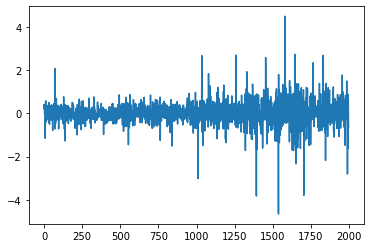

In [12]:
training = list(train_data.values)

model = ARIMA(training, order=(4,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
plt.plot(model_fit.resid)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1999
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -1499.724
Method:                       css-mle   S.D. of innovations              0.512
Date:                Sun, 13 Dec 2020   AIC                           3013.448
Time:                        21:55:47   BIC                           3052.651
Sample:                             1   HQIC                          3027.843
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0252      0.009      2.712      0.007       0.007       0.043
ar.L1.D.y      0.7126      0.101      7.054      0.000       0.515       0.911
ar.L2.D.y      0.0326      0.028      1.174      0.2

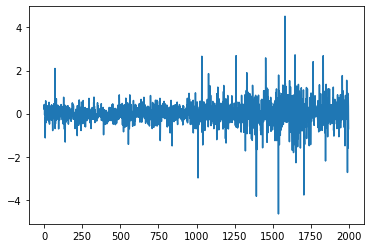

In [13]:
model = ARIMA(training, order=(4,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
plt.plot(model_fit.resid)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1999
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1502.058
Method:                       css-mle   S.D. of innovations              0.513
Date:                Sun, 13 Dec 2020   AIC                           3018.116
Time:                        21:55:47   BIC                           3057.319
Sample:                             1   HQIC                          3032.511
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0252      0.010      2.418      0.016       0.005       0.046
ar.L1.D.y     -0.0404      0.022     -1.805      0.071      -0.084       0.003
ar.L2.D.y      0.0030      0.022      0.135      0.8

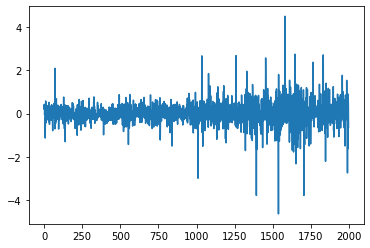

In [14]:
model = ARIMA(training, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
plt.plot(model_fit.resid)

/home/urosm/.local/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/home/urosm/.local/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/urosm/.local/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2000
Model:                     ARMA(4, 0)   Log Likelihood               -1516.449
Method:                       css-mle   S.D. of innovations              0.514
Date:                Sun, 13 Dec 2020   AIC                           3044.897
Time:                        22:04:33   BIC                           3078.502
Sample:                             0   HQIC                          3057.236
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.6770        nan        nan        nan         nan         nan
ar.L1.y        0.9632   7.06e-06   1.36e+05      0.000       0.963       0.963
ar.L2.y        0.0422      0.022      1.909      0.0

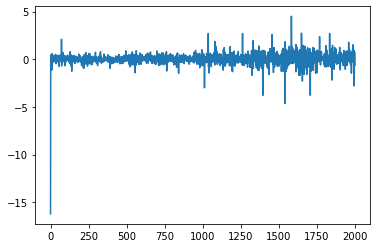

In [24]:
#One degree of differencing is needed
model = ARIMA(training, order=(4,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
plt.plot(model_fit.resid)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1999
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -1497.220
Method:                       css-mle   S.D. of innovations              0.512
Date:                Sun, 13 Dec 2020   AIC                           3010.441
Time:                        21:55:50   BIC                           3055.244
Sample:                             1   HQIC                          3026.892
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0251      0.010      2.542      0.011       0.006       0.044
ar.L1.D.y      1.3492      0.130     10.356      0.000       1.094       1.605
ar.L2.D.y     -0.6076      0.200     -3.038      0.0

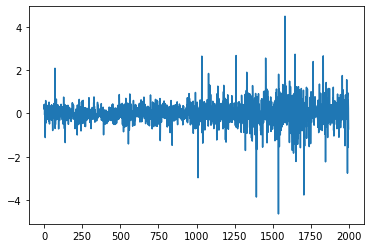

In [16]:
model = ARIMA(training, order=(4,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())
plt.plot(model_fit.resid)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1999
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -1504.273
Method:                       css-mle   S.D. of innovations              0.514
Date:                Sun, 13 Dec 2020   AIC                           3018.546
Time:                        21:55:51   BIC                           3046.548
Sample:                             1   HQIC                          3028.828
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0252      0.011      2.268      0.023       0.003       0.047
ar.L1.D.y     -0.0394      0.022     -1.760      0.078      -0.083       0.004
ar.L2.D.y      0.0028      0.022      0.124      0.9

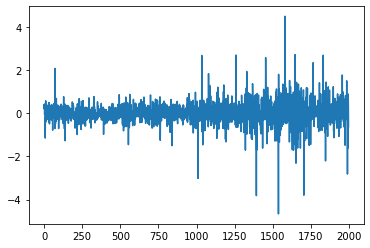

In [17]:
model = ARIMA(training, order=(3,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
plt.plot(model_fit.resid)

# Testing on 100 successive days
The ARIMA model can only predict the next value in a time series so I tested the model 100 times and calculated the loss functions.  
Chosen models: ARIMA(4,1,0), ARIMA(4,1,1) and ARIMA(3,1,0) 

In [18]:
test = test_data.values
history = list(train_data.values)
predictions = list()

for i in range(len(test)):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predictions.append(output[0])
    history.append(test[i])

print('Mean Squared Error: %.3f' % mse(test, predictions))
print('Symmetric mean absolute percentage error: %.3f' % smape(test, predictions))

Mean Squared Error: 0.615
Symmetric mean absolute percentage error: 5.733


In [19]:
test = test_data.values
history = list(train_data.values)
predictions = list()

for i in range(len(test)):
    model = ARIMA(history, order=(4,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predictions.append(output[0])
    history.append(test[i])

print('Mean Squared Error: %.3f' % mse(test, predictions))
print('Symmetric mean absolute percentage error: %.3f' % smape(test, predictions))

Mean Squared Error: 0.624
Symmetric mean absolute percentage error: 5.717


In [20]:
test = test_data.values
history = list(train_data.values)
predictions = list()

for i in range(len(test)):
    model = ARIMA(history, order=(3,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predictions.append(output[0])
    history.append(test[i])

print('Mean Squared Error: %.3f' % mse(test, predictions))
print('Symmetric mean absolute percentage error: %.3f' % smape(test, predictions))

Mean Squared Error: 0.613
Symmetric mean absolute percentage error: 5.734


# Results
There is no substantial diference between ARIMA(4,1,0), ARIMA(4,1,1) i ARIMA(3,1,0) as was seen from the summary() function and from the loss functions. The model ARIMA(3,1,0) got the lowest MSE value while ARIMA(4,1,1) got the lowest SMAPE value.  
Predicted and real values are visualized bellow.

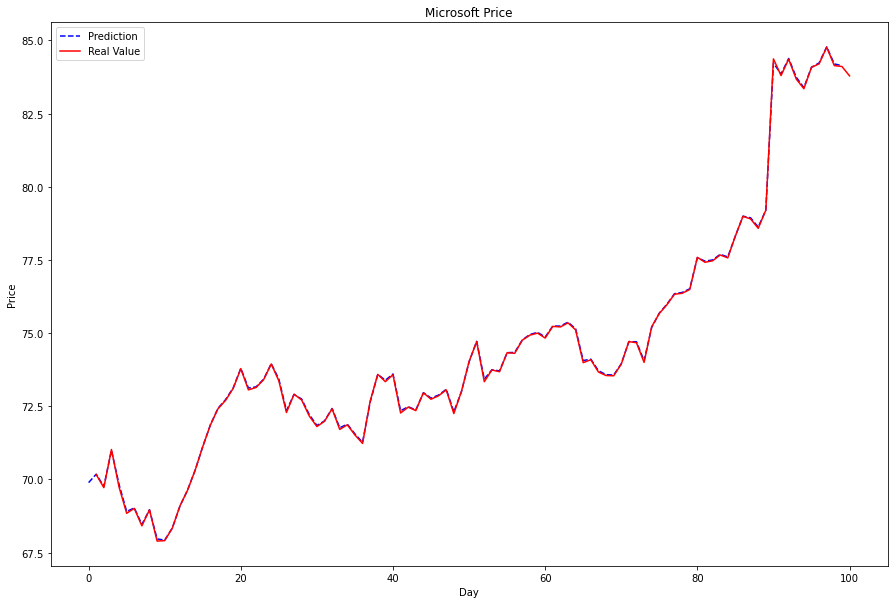

In [21]:
plt.figure(figsize=(15,10))
plt.plot(range(len(test)), predictions, color='blue', linestyle='dashed',label='Prediction')
plt.plot(range(1,len(test)+1), test, color='red', label='Real Value')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Microsoft Price')
plt.legend()
plt.show()

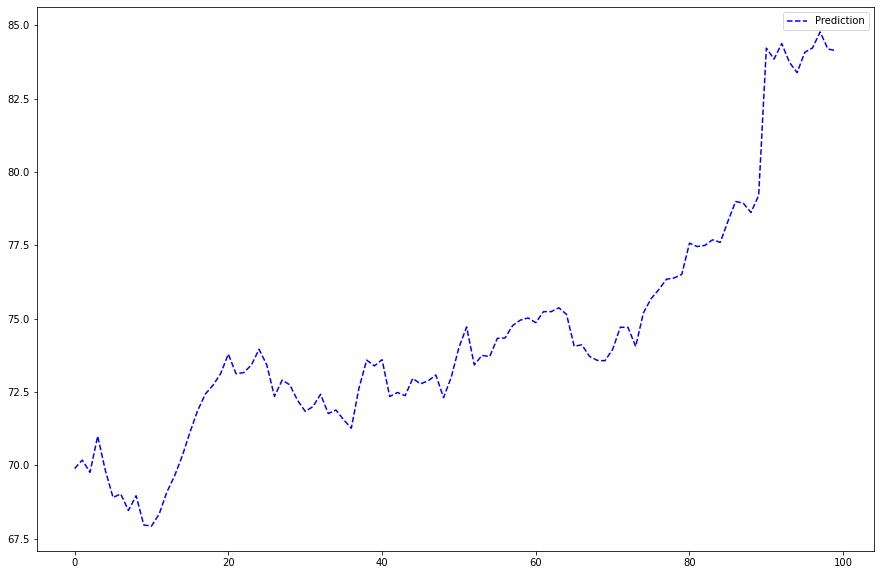

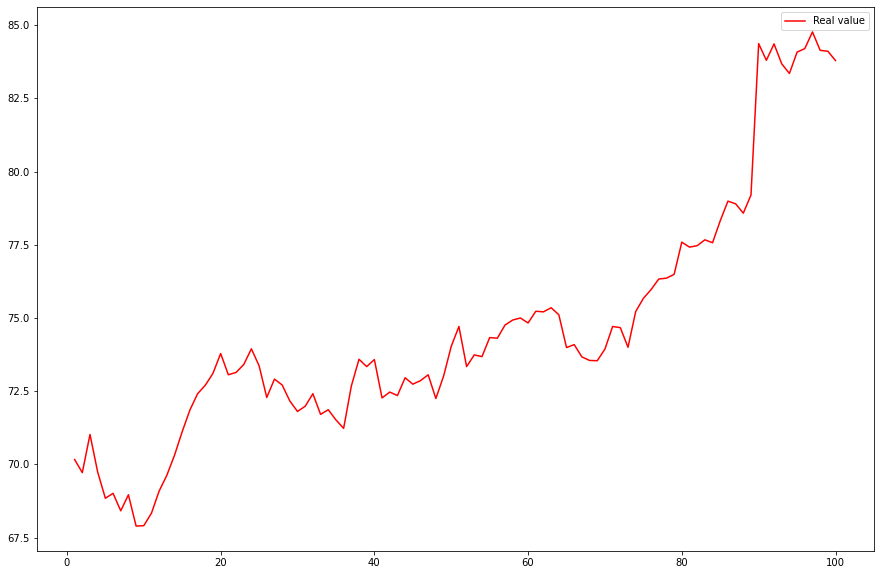

In [23]:
plt.figure(figsize=(15,10))
plt.plot(range(len(test)), predictions, color='blue', linestyle='dashed',label='Prediction')
plt.legend()
plt.show()
plt.figure(figsize=(15,10))
plt.plot(range(1,len(test)+1), test, color='red', label='Real value')
plt.legend()
plt.show()